# Permeability-related figures
This notebook reproduces result figures in the paper that came from the fixed diameter cases, with either no MT or permeability at all (Figure 4) or permeability only (Figure 5)

In [1]:
# First import the relevant packages and functions
from local_optim_fit import forge_axcaliber, fit_params
from dmipy.signal_models import gaussian_models, cylinder_models
from dmipy.core.acquisition_scheme import acquisition_scheme_from_qvalues
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from dmipy.distributions import distribute_models
from scipy.optimize import curve_fit, minimize
import pandas as pd
from scipy.stats import gamma
from dmipy.core.acquisition_scheme import acquisition_scheme_from_gradient_strengths
from scipy.interpolate import CubicSpline, interp1d
from matplotlib.ticker import LinearLocator
import copy
import pickle

/Users/zxh380/opt/anaconda3/envs/dmipy/lib/python3.12/site-packages/dmipy-1.0.5-py3.12.egg/dmipy/utils/utils.py:6: UserWarning: Pass ['name'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an error. 
/Users/zxh380/opt/anaconda3/envs/dmipy/lib/python3.12/site-packages/dmipy-1.0.5-py3.12.egg/dmipy/optimizers_fod/csd_cvxpy.py:8: UserWarning: Pass ['name'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an error. 
/Users/zxh380/opt/anaconda3/envs/dmipy/lib/python3.12/site-packages/dmipy-1.0.5-py3.12.egg/dmipy/optimizers_fod/csd_tournier.py:6: UserWarning: Pass ['name'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an error. 
/Users/zxh380/opt/anaconda3/envs/dmipy/lib/python3.12/site-packages/dmipy-1.0.5-py3.12.egg/dmipy/optimizers_fod/csd_plus.py:10: UserWarning: Pass ['name'] as keyword args. From version 2.0.0 passing these as positional arguments will result in a

### Fit the raw data
We use two custom functions based on dmipy package and scipy to create our forward model -- the two-compartment model (`forge_axcaliber`), and fit the model to simulated data (`fit_params`).

In [ ]:
# Create lists to store fitted parameters and fitting costs (squared errors)
cost_mat = []
param_mat = []
# Call the custom function to construct the forward model from interpolating simulated dictionary of intraaxonal signals at different radius values.
forward_model = forge_axcaliber()
# Loop through the relevant permeability and radius values and fit the forward model to the total signal 
for perm in np.arange(0, 0.021, 0.001):
    costs = []
    params = []
    for i in np.arange(0.30, 5.51, 0.10):
        # read the relevant signal file
        simdata = pd.read_csv("./perm_results/signal_MT_0_sus_0_perm_" + '{0:.3f}'.format(perm) + "_rmean_" + '{0:.2f}'.format(i) + "_density_0.65.csv", header=None)
        y = simdata[2].to_numpy()/simdata[2][0]
        # Fit the model using the custom function which performs a least square fitting
        cost, param = fit_params(forward_model, y)
        # Store the fitting costs and fitted parameters in the correct lists
        costs.append(cost)
        params.append(param)
    cost_mat.append(costs)
    param_mat.append(params)

To skip fitting parameters from raw data, use the pre-fitted parameters

In [3]:
file_path = "precomputed_perm_params.pickle"
with open(file_path, 'rb') as file:
    params = pickle.load( file)

## Figure 4: Parameter estimation and simulated signal with no permeability or MT

### Figure 4a
Plot the fitted diameters across the range of underlying diameters

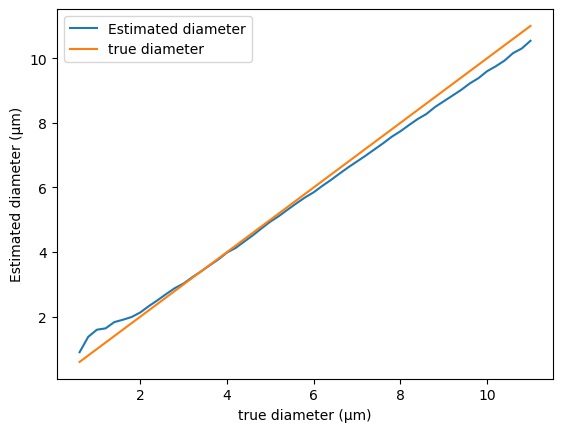

In [12]:
# Extract the 1st element which doesn't have any MT or permeability
param = params[0] 
# Make a list to store fitted diameter
nm_rfit = []
# Loop through and extract the fitted diameter (the third sub-element)
for a in param:
    nm_rfit.append(a["Nelder-Mead"][2])
# Plot the list
plt.plot(np.arange(0.60, 11.01, 0.20),np.array(nm_rfit)*2, label="Estimated diameter")
# Plot the true value for reference
plt.plot(np.arange(0.30, 5.51, 0.10)*2,np.arange(0.30, 5.51, 0.10)*2, label="true diameter")
plt.xlabel("true diameter (μm)")
plt.ylabel("Estimated diameter (μm)")
plt.legend()
plt.show()

### Figure 4b
Plot the fitted volume fraction across the range of underlying diameters

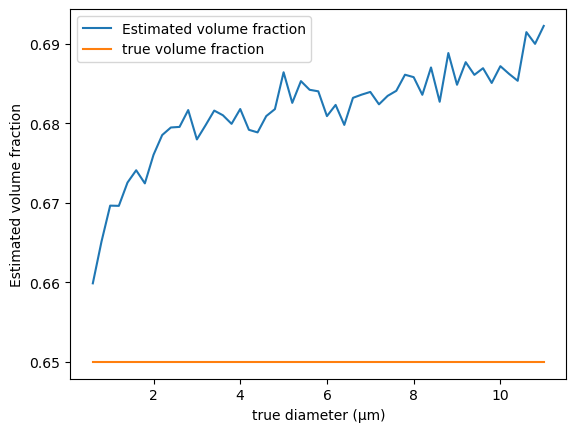

In [11]:
# Extract the 1st element which doesn't have any MT or permeability
param = params[0]
# Make a list to store fitted diameter
nm_vfit = []
# Loop through and extract the fitted volume fraction (the first sub-element)
for a in param:
    nm_vfit.append(a["Nelder-Mead"][0])
# Plot the list    
plt.plot(np.arange(0.60, 11.01, 0.20),np.array(nm_vfit), label="Estimated volume fraction")
# Plot the true value for reference
plt.plot([0.6,11],[0.65,0.65], label="true volume fraction")
plt.xlabel("true diameter (μm)")
plt.ylabel("Estimated volume fraction")
plt.legend()
plt.show()

### Figure 4c
Verify the spline interpolated dictionary by plotting its estimated diameters from just the intra-axonal signal against the true dameters. First we define two custom functions that build the interpolated dictionary (`get_spline`) and fir the interpolated dictionary to the intra-axonal signal (`fit_cyl_model`).

In [1]:
def get_spline():
    gradient_strengths = np.squeeze(np.tile(np.arange(0, 1.21, 0.08), (1,8)) )  # T/m
    gradient_directions = np.tile(np.array([0,1,0]), (128, 1))  # Perpendicular to the cylinder, same for all sequences
    delta = 0.0025  # gradient duration (s)
    Delta = np.tile(np.array([0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08]), (16,1)).transpose().flatten()        # diffusion time (s)
    acq_scheme = acquisition_scheme_from_gradient_strengths(gradient_strengths, gradient_directions, delta, Delta)    # construct the sequence (acquisition scheme) object in dmipy
    ys = [np.ones([128])] # Add first dictionary element as a cylinder with 0 radius should have attenuation of 1

    #Loop through all radius values and read the signal and calculate the DW signal attenuation and append the values to the dictionary
    for i in np.arange(0.30, 5.51, 0.10):
        simdata = pd.read_csv("./perm_results/signal_MT_0_sus_0_perm_0.000_rmean_" + '{0:.2f}'.format(i) + "_density_0.65.csv",header=None)
        y = simdata[0].to_numpy()/simdata[0][0] # calculate the intraaxonal DW signal attenuation by dividing the signal magnitude by the b0 signal magnitude
        ys.append(y)
    np_ys = np.array(ys) # Convert to numpy array for fitting
    rs = np.arange(0.30, 5.51, 0.10) # Create a numpy array to store corresponding radius values
    rs = np.insert(rs, 0, 0)
    ax_intra = CubicSpline(rs, np_ys) # Interpolate the dictionary using cubic spline
    # Returns a function that can be used as a forward model to fit signals, x needed even though the function is independent of x as curve_fit requires an xdata term.
    def spline_with_x(x, r):
        return ax_intra(r)

    return spline_with_x

def fit_cyl_model(y, r, extrapolate=False):
    gradient_strengths = np.squeeze(np.tile(np.arange(0, 1.21, 0.08), (1,8)) )  # T/m
    gradient_directions = np.tile(np.array([0,1,0]), (128, 1))  # Perpendicular to the cylinder, same for all sequences
    delta = 0.0025  # gradient duration (s)
    Delta = np.tile(np.array([0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08]), (16,1)).transpose().flatten()  # diffusion time (s)
    initial_params = [r]
    acq_scheme = acquisition_scheme_from_gradient_strengths(gradient_strengths, gradient_directions, delta, Delta) # construct the sequence (acquisition scheme) object in dmipy
    f = get_spline() # define the forward model to be fitted
    # Perform curve fitting using least squares, extrapolate is usually bad so default is false
    if extrapolate:
        popt, pcov = curve_fit(f=f, xdata=0, ydata=y, p0=initial_params, maxfev=5000)
    else:
        popt, pcov = curve_fit(f=f, xdata=0, ydata=y, p0=initial_params, maxfev=5000, bounds=(0.1,10.1))
    
    # Print the optimal parameters
    print('Fitted radius(um):', popt[0])
    # return the fitting results
    return popt

Apply the fitting function to fit the diameters across the underlying radius range

In [32]:
r_dict = []
# Loop through the revelant radius range and read the signal
for i in np.arange(0.30, 5.51, 0.10):
    simdata = pd.read_csv("./perm_results/signal_MT_0_sus_0_perm_0.000_rmean_" + '{0:.2f}'.format(i) + "_density_0.65.csv", header=None)
    r = 0.4                                           # give the fitting algorithm a valid initial guess
    y = np.array(simdata[0].to_numpy()/simdata[0][0]) # calculate the intraaxonal DW attenuation
    popt = fit_cyl_model(y=y, r=r)                    # Fit the cylinder diameter
    r_dict.append(popt[0])                            # Store the fitted values

Fitted radius(um): 0.30001991011755047
Fitted radius(um): 0.4
Fitted radius(um): 0.500000504505856
Fitted radius(um): 0.600000011606289
Fitted radius(um): 0.7000000010619415
Fitted radius(um): 0.8
Fitted radius(um): 0.9000000000258399
Fitted radius(um): 1.000000000000021
Fitted radius(um): 1.1000000023031038
Fitted radius(um): 1.2000000184815334
Fitted radius(um): 1.3000000000000018
Fitted radius(um): 1.3999999999994317
Fitted radius(um): 1.5000000000000069
Fitted radius(um): 1.5999999999477037
Fitted radius(um): 1.700000000116706
Fitted radius(um): 1.8000000000000034
Fitted radius(um): 1.9000000000042012
Fitted radius(um): 2.000000000464
Fitted radius(um): 2.1000000004262827
Fitted radius(um): 2.200000000000002
Fitted radius(um): 2.3000000000000016
Fitted radius(um): 2.40000000000004
Fitted radius(um): 2.500000000000008
Fitted radius(um): 2.60000000000026
Fitted radius(um): 2.7000000000000064
Fitted radius(um): 2.800000000000019
Fitted radius(um): 2.900000000000001
Fitted radius(um): 

Plot the spline fitted diameter using only intraaxonal signal across the range of underlying diameters.

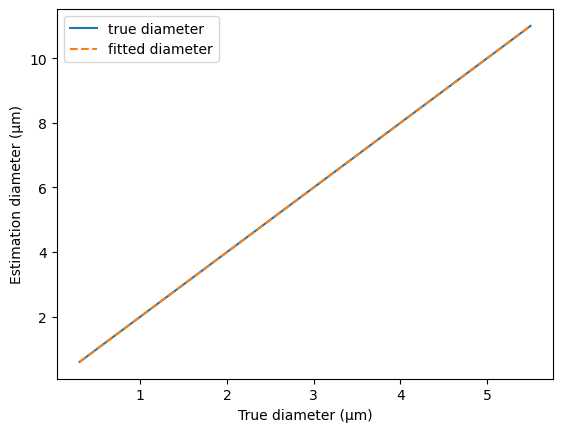

In [60]:
np_r_dict = np.array(r_dict)
rs = np.arange(0.30, 5.51, 0.1)
plt.plot(rs,rs*2,label="true diameter")                              # plot the true diameter for reference
plt.plot(rs, np_r_dict*2, label="fitted diameter", linestyle='--')   # plot the fitted diameters
plt.xlabel("True diameter (μm)")
plt.ylabel("Estimation diameter (μm)")
plt.legend()
plt.show()


### Figure 4d 
Plot the extraaxonal signal to inspect its non-Gaussianity.

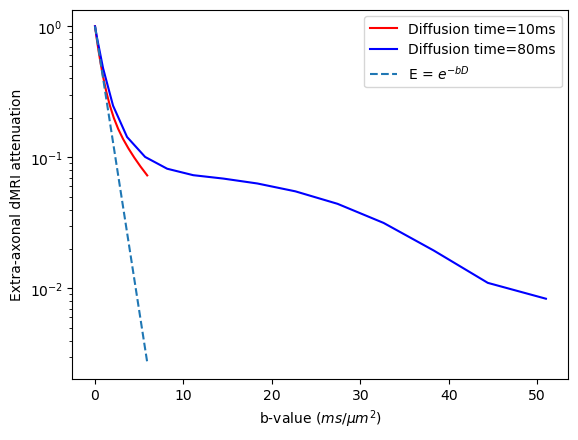

In [61]:
simdata = pd.read_csv("perm_results/signal_MT_0_sus_0_perm_0.000_rmean_5.50_density_0.65.csv", header=None) # read the signal file
y = simdata[1].to_numpy()/simdata[1][0] # calculate the extraaxonal DW signal attenuation
gradient_strengths = np.squeeze(np.tile(np.arange(0, 1.21, 0.08), (1,8)) )  # T/m
gradient_directions = np.tile(np.array([0,1,0]), (128, 1)) # Perpendicular to the cylinder, same for all sequences
delta = 0.0025  # gradient duration (s)
Delta = np.tile(np.array([0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08]), (16,1)).transpose().flatten()  # diffusion time (s)
acq_scheme = acquisition_scheme_from_gradient_strengths(gradient_strengths, gradient_directions, delta, Delta) # form the acquisition scheme object from dmipy so bvalues and other parameters are automatically calculated
# Plot the extraxonal DW signal attenuation at Δ=10ms and Δ=80ms and plot the free diffusion analytical prediction for reference
plt.semilogy(acq_scheme.bvalues[0:16]*1e-9, (y[0:16]), c='red', label="Diffusion time=10ms")
plt.semilogy(acq_scheme.bvalues[112:128]*1e-9, (y[112:128]), c='blue', label="Diffusion time=80ms")
plt.semilogy(acq_scheme.bvalues[0:16]*1e-9, np.exp(-acq_scheme.bvalues[0:16]*1e-9), label="E = ${e^{-bD}}$", linestyle='--')
plt.xlabel("b-value ($ms/μm^2$)")
plt.ylabel("Extra-axonal dMRI attenuation");
plt.legend()
plt.show()

## Figure 5: Diameter (5a) and IVF (5b) estimation with semi-permeable cylinders, uniform diameter

### Figure 5a
Plot the fitted diameters across the range of underlying diameters at different permeability values

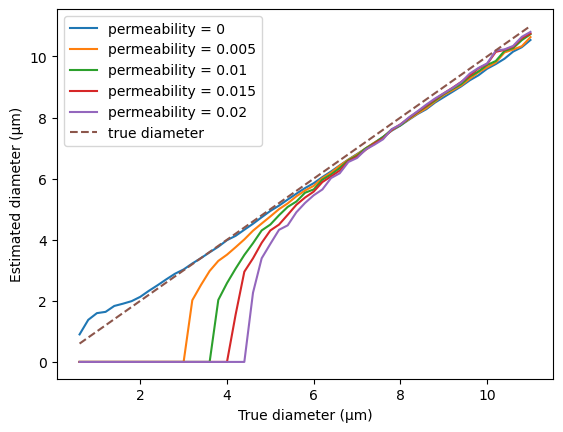

In [10]:
# List the permeability values of interest
perm_list = [0, 0.005, 0.01, 0.015, 0.02]
# Loop through the parameter storage list and get the correct elements
for index in range(5):
    param = params[index*5]
    # For each permeability values extract the fitted diameters into a new list
    nm_rfit = []
    for a in param:
        nm_rfit.append(a["Nelder-Mead"][2])
    # Then plot the list of fitted values
    plt.plot(np.arange(0.60, 11.01, 0.20),np.array(nm_rfit)*2, label="permeability = " + str(perm_list[index]))
# Plot the true value for reference
plt.plot(np.arange(0.30, 5.51, 0.10)*2,np.arange(0.30, 5.51, 0.10)*2, label="true diameter", linestyle='--')
plt.xlabel("True diameter (μm)")
plt.ylabel("Estimated diameter (μm)")
plt.legend()
plt.show()

### Figure 5b
Plot the fitted volume fractions across the range of underlying diameters at different permeability values

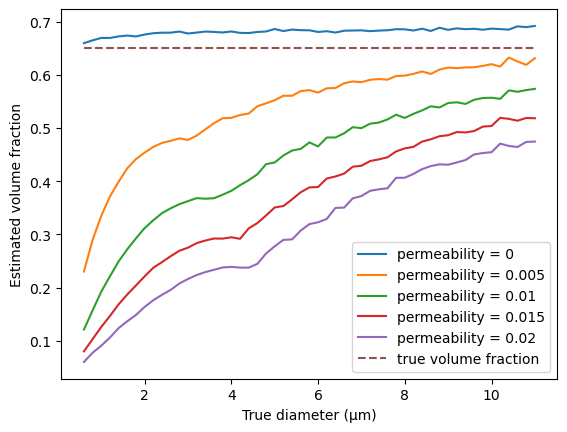

In [13]:
# List the permeability values of interest
perm_list = [0, 0.005, 0.01, 0.015, 0.02]
# Loop through the parameter storage list and get the correct elements
for index in range(5):
    param = params[index*5]
    # For each permeability values extract the fitted diameters into a new list
    nm_vfit = []
    for a in param:
        nm_vfit.append(a["Nelder-Mead"][0])
    # Then plot the list of fitted values
    plt.plot(np.arange(0.60, 11.01, 0.20),np.array(nm_vfit), label="permeability = " + str(perm_list[index]))
# Plot the true value for reference
plt.plot([0.6,11],[0.65,0.65], label="true volume fraction", linestyle='--')
plt.xlabel("True diameter (μm)")
plt.ylabel("Estimated volume fraction")
plt.legend()
plt.show()